# Data Analysis

## Setup
### Import libraries
```wordlemodule.py``` defines a custom class I wrote to create and perform calculations on Wordle objects.

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import Code.wordlemodule
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

### Open data from saved file and create a WordleModule object with it
The data is loaded from the pickle file, and a new wordle object called "data" is created. Most of the calculations are contained within methods of the class or the module, and graphing/display is handled within this Jupyter notebook.

In [6]:
# Open pickle file
with open('Data/Script data/Imported_email_data_with_ints.pkl','rb') as file:
    full_data = pickle.load(file)

# Create custom wordle object with input data
data = Code.wordlemodule.WordleData(full_data)

## Plots

### Mean solve score

The first value of interest is the mean solve score per person, where solve score is the number of guesses it took until the puzzle was completely solved (all green in one row). For example, if it only took three guesses to fully guess the word, then the solve score is three.

In Panel A, data is shown as a box plot denoting the interquartile range and median in thin black lines, mean as a thick purple dashed line, and outliers as black-rimmed white circle.

In Panel B, the frequency of each solve score is shown in a histogram. Additionally, the histogram shows the frequency of unsolved puzzles (failing to guess the word in 6 guesses). For example, for one player the frequency of unsolved puzzles almost equals the frequency of a solve score of 6.

Panel C shows the same histogram data normalized so that the sum of each player's values equals 1. Here, it is more apparent that player 4 (red) has an increased rate of solving the puzzle with 4 guesses as compared to the other players.


C:\Users\Andrés\AppData\Local\Temp\ipykernel_11924\586475863.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])
C:\Users\Andrés\AppData\Local\Temp\ipykernel_11924\586475863.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])


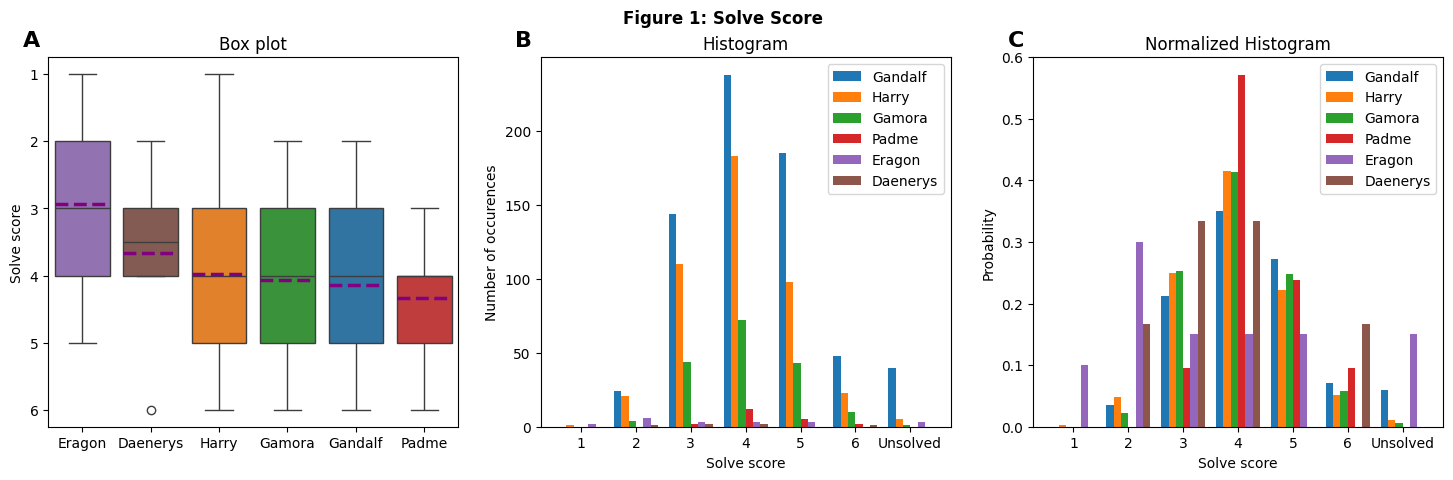

In [7]:
# Create figure with two subplots
f,ax = plt.subplots(1,3)
f.set_figwidth(18)
f.suptitle('Figure 1: Solve Score',fontweight='bold')

# Subplot 1: Plot mean solve score
df = data.as_df()
df = df.drop('Puzzle Number',axis=1).replace(7,np.nan)
sorted_cols = df.mean().sort_values(ascending=True)
df_sorted = df[sorted_cols.index]

meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
sns.boxplot(data=df_sorted,
               ax=ax[0],
               showmeans = True,
               meanline = True,
               meanprops = meanlineprops,
               legend='auto',
               #whis=2,
               hue_order = df.keys())

ax[0].set(ylabel = 'Solve score',
          title = 'Box plot')
ax[0].invert_yaxis()


# Subplot 2: Plot a histogram of solve score
ax[1].hist(data.data_arr,
           bins=np.arange(0.5,8.5,1),
           density=False)

ax[1].set_ylabel('Number of occurences')
ax[1].set_xlabel('Solve score')
ax[1].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])
ax[1].set_title('Histogram')
ax[1].legend(data.data_dict.keys())


# Subplot 3: Plot a histogram of solve score
ax[2].hist(data.data_arr,
           bins=np.arange(0.5,8.5,1),
           density=True)

ax[2].set_ylabel('Probability')
ax[2].set_xlabel('Solve score')
ax[2].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])
ax[2].set_title('Normalized Histogram')
ax[2].legend(data.data_dict.keys())

# Add panel labels
labels = ['A','B','C']
for i in range(len(ax)):
      ax[i].text(-0.02,1.02, labels[i],
            transform=ax[i].transAxes,
            fontsize=16, fontweight='bold', va='bottom', ha='right')

## General statistics and streaks

Pretty self-explanatory. All the categories are only based on puzzles in the period from the first puzzle to the last puzzle submitted, so for example "puzzles not attempted" only includes puzzles not attempted from puzzle numbers 220-250 if #220 was the first puzzle submitted and #250 was the last.

From this data it is apparent that some players had much higher variability in their solve score than other more consistent players. For example, player 5's solve score standard deviation is 1.9, more than twice the least variable player, player 3 with 0.93. Additionally, some players never solved a puzzle in a single try. Lastly, player 1 submitted scores every 1.48 days on average, almost twice as often as the next highest, player 2 with an average of 2.28 days between puzzles.

In [8]:
data.stats()

,Mean solve score,Solve score standard deviation,Best solve score,Puzzles attempted,Puzzles not attempted,Longest not attempted puzzle streak,Longest attempted puzzle streak,Mean days between puzzles
Person,,,,,,,,
Gandalf,4.307806,1.160224,2,679,327,22,55,1.482301
Harry,4.009070,0.997683,1,441,564,28,19,2.281818
Gamora,4.080460,0.933864,2,174,801,135,14,5.630058
Padme,4.333333,0.795822,3,21,140,44,3,8.000000
Eragon,3.550000,1.932411,1,20,117,61,4,7.157895
Daenerys,3.666667,1.366260,2,6,200,92,2,41.000000


### Solve score over time

Did people improve their average scores over time?

To answer this question, we first want to inspect how scores change over time. However, the quantized nature of the scores (1, 2 ... 6) makes them hard to interpret in a standard scatter plot or line plot. Therefore, the moving average of scores (aka a sliding window mean) as a function of puzzle number is shown in Panel A instead. (If there are not sufficient scores to calculate the mean given the window size, a warning is shown and that data is excluded.)

In Panel B, a linear regression model is generated from the solve scores and predicted values are shown in a line graph over the range of puzzles they completed. A negative slope indicates that the player worsened over time, and a positive slope indicates improvement over time.

c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\Code\wordlemodule.py:230: UserWarning: Eragon only has 20 values, which is not enough to calculate using a sliding widow size of 20
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')
c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\Code\wordlemodule.py:230: UserWarning: Daenerys only has 6 values, which is not enough to calculate using a sliding widow size of 20
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')


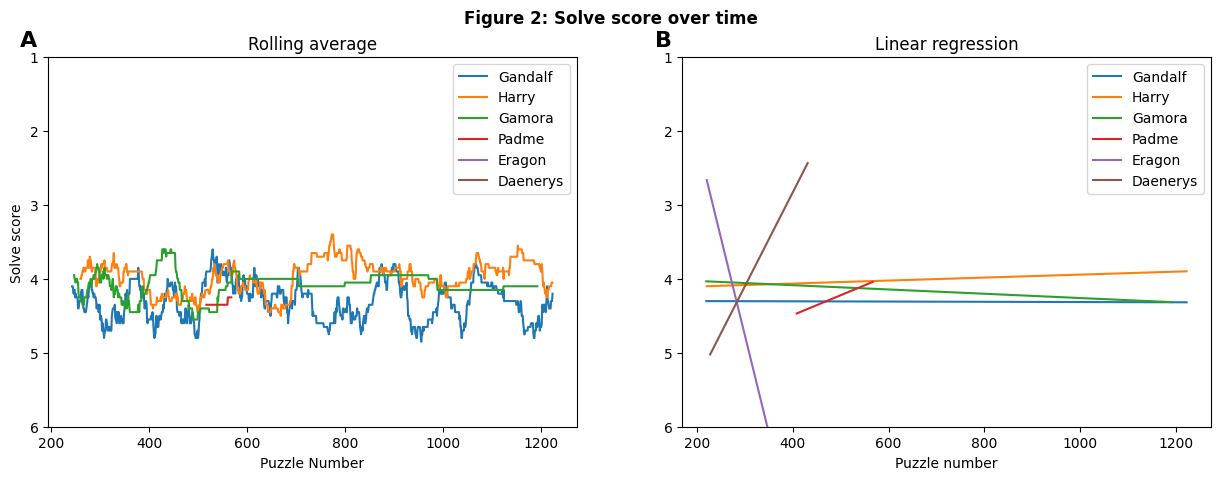

In [9]:
# Set up pandas dataframe with rolling average
df = data.rolling(20)

# Set up figure for plotting
myfig, myax = plt.subplots(1,2)

# Plot scatterplot for solve score over time
df.plot(title="Rolling average",
               subplots=False,
               ax=myax[0], 
               ylim=[6,1], 
               yticks=range(1,7,1),
               xlabel='Puzzle Number',
               ylabel='Solve score',
               )

# Plot linear regression
df_predicted = data.linear_reg()
df_predicted.plot(
    title='Linear regression',
    ax=myax[1],
    ylim=[6,1], 
    xlabel='Puzzle number'
)



# Set figure properties
myfig.suptitle('Figure 2: Solve score over time', fontweight='bold')
myfig.set_figwidth(15)

# Add panel labels
labels = ['A','B','C']
for i in range(len(myax)):
      myax[i].text(-0.02,1.02, labels[i],
            transform=myax[i].transAxes,
            fontsize=16, fontweight='bold', va='bottom', ha='right')

### By week-day
Does solve score depened on the day of the week? For example, people may have more time to think about guesses on weekends, and therefore have higher scores on weekends as compared to weekdays. And what about the number of puzzles attempted on weekends vs weekdays?

The total number of puzzles attempted was vastly different for each player (Panel A). Some players attempt more puzzles on the weekdays, whereas others tended to attempt more on the weekends (Panel B), probably indicating differences in job requirements and how busy their weekends were. Overall, there was not a difference in numbers of puzzles completed on weekends vs weekdays (Panel C).

Generally, the solve score of each player was not significantly different between weekends and weekdays (Panels D-F), although higher variability is seen from scores with low sample size.

For all panels, black lines on bars indicate standard error of the mean.

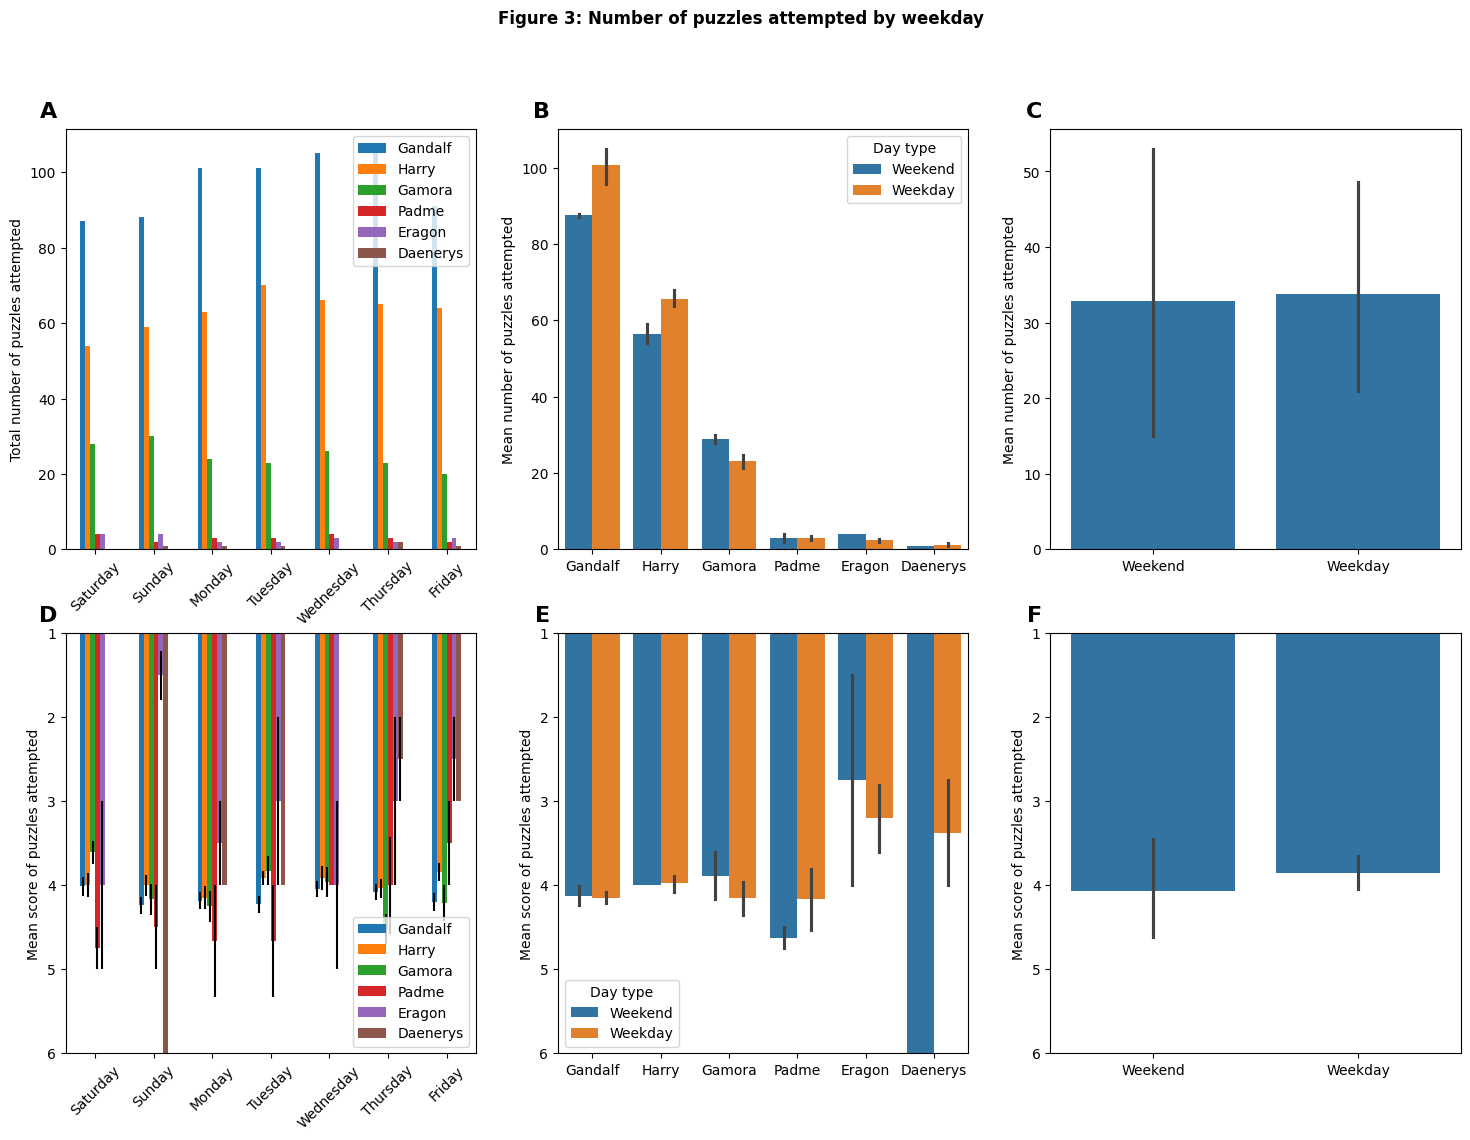

In [10]:
# Use the Wordle object functions to return 
df_weekly_sum, df_weekly_score, df_weekly_score_sem = data.weekly()

# Create figure and axes for subplots
f, myax = plt.subplots(2, 3)
f.set_figwidth(18)
f.set_figheight(12)
f.suptitle('Figure 3: Number of puzzles attempted by weekday', fontweight='bold')

# Subplot column 0: number/score of puzzles attempted
df_weekly_sum.plot.bar(ylabel='Total number of puzzles attempted',
                       xlabel='',
                       rot=45,
                       ax=myax[0,0])
#sns.barplot(df_weekly_score)
df_weekly_score.plot.bar(ylabel='Mean score of puzzles attempted',
                       xlabel='',
                       rot=45,
                       ax=myax[1,0],
                       yerr=df_weekly_score_sem)
myax[1,0].set_ylim(6,1)

# Add a weekday and weekend variable and change to long-form data
df_weekly_sum['Day type'] = 'Weekday'
df_weekly_score['Day type'] = 'Weekday'
weekends = ['Sunday','Saturday']

df_weekly_sum.loc[weekends,'Day type'] = 'Weekend'
df_weekly_sum_long = pd.melt(df_weekly_sum, id_vars='Day type', var_name='Person', value_name='Value')


df_weekly_score.loc[weekends,'Day type'] = 'Weekend'
df_weekly_score_long = pd.melt(df_weekly_score, id_vars='Day type', var_name='Person', value_name='Value')

# Subplot column 1: number/score of puzzles attempted, by weekend and weekday and by person
sns.barplot(df_weekly_sum_long,
            x = 'Person',
            y = 'Value',
            hue = 'Day type',
            legend=True,
            ax=myax[0,1])
myax[0,1].set(ylabel = 'Mean number of puzzles attempted',xlabel='')

sns.barplot(df_weekly_score_long,
            x = 'Person',
            y = 'Value',
            hue = 'Day type',
            legend=True,
            ax=myax[1,1])
myax[1,1].set(ylabel = 'Mean score of puzzles attempted',xlabel='')
myax[1,1].set_ylim(6,1)

# Subplot column 2: number/score of puzzles attempted, by weekend and weekday
sns.barplot(data=df_weekly_sum_long,
            x = 'Day type',
            y = 'Value',
            legend=True,
            ax=myax[0,2])
myax[0,2].set(ylabel = 'Mean number of puzzles attempted',xlabel='')

sns.barplot(df_weekly_score_long,
            x = 'Day type',
            y = 'Value',
            legend=True,
            ax=myax[1,2])
myax[1,2].set(ylabel = 'Mean score of puzzles attempted',xlabel='')
myax[1,2].set_ylim(6,1)

# Add panel labels
labels = ['A','B','C','D','E','F']
for i in range(myax.shape[0]):
      for j in range(myax.shape[1]):
            myax[i,j].text(-0.02,1.02, labels[(myax.shape[0]*i)+i+j],
                  transform=myax[i,j].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='right')

### How correlated are player's guesses?
Are the same words difficult for the same players? Are certain players more similar in their guesses and play style?

In panel A, a simple Pearson correlation coefficient is calculated by comparing each puzzle completed by two players. Values close to 0 indicate low correlation, whereas values far from 0 indicate higher correlation. For example, the highest positive correlation was around 0.5, indicating high similarity of results between these two players. The "highest" negative correlation was around -0.6, indicating that these two players had highly different results (where one did well, the other did poorly on a given Wordle). To show the data more visuzlly, Panel B shows the result of each Wordle puzzle, where redder color indicates a worse outcome (solve score is close to taking 6 guesses) and cooler colors are better outcomes (solve score closer to 1). Since results are quantized and not continuous (results can only be 1,2,3,4,5,or 6), a rolling average of every 19 puzzles in shown.

Finally, what are the correlations between individual players? In the last panel, each sub-graph shows the scatterplot of solve scores between individual players. For example, a dot at position (1,6) in the sub-graph indicates that the player shown on the horizontal axis solved that Wordle in 1 guess, whereas the player shown on the vertical axis took 6 guesses to solve that same puzzle. A linear regression is calculated from these scores, and their slopes (the degree of similarity) correspond to the pearson correlation values shown in Panel A. 

Surprisingly, these results indicate that instead of all players having some level of (positive) correlation, some are even in fact highly anti-correlated.

c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\Code\wordlemodule.py:230: UserWarning: Daenerys only has 6 values, which is not enough to calculate using a sliding widow size of 19
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')


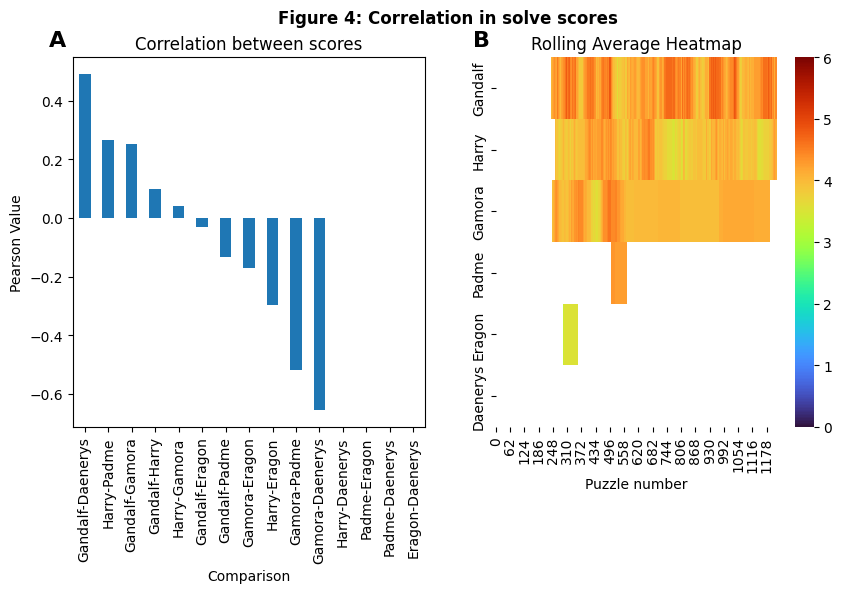

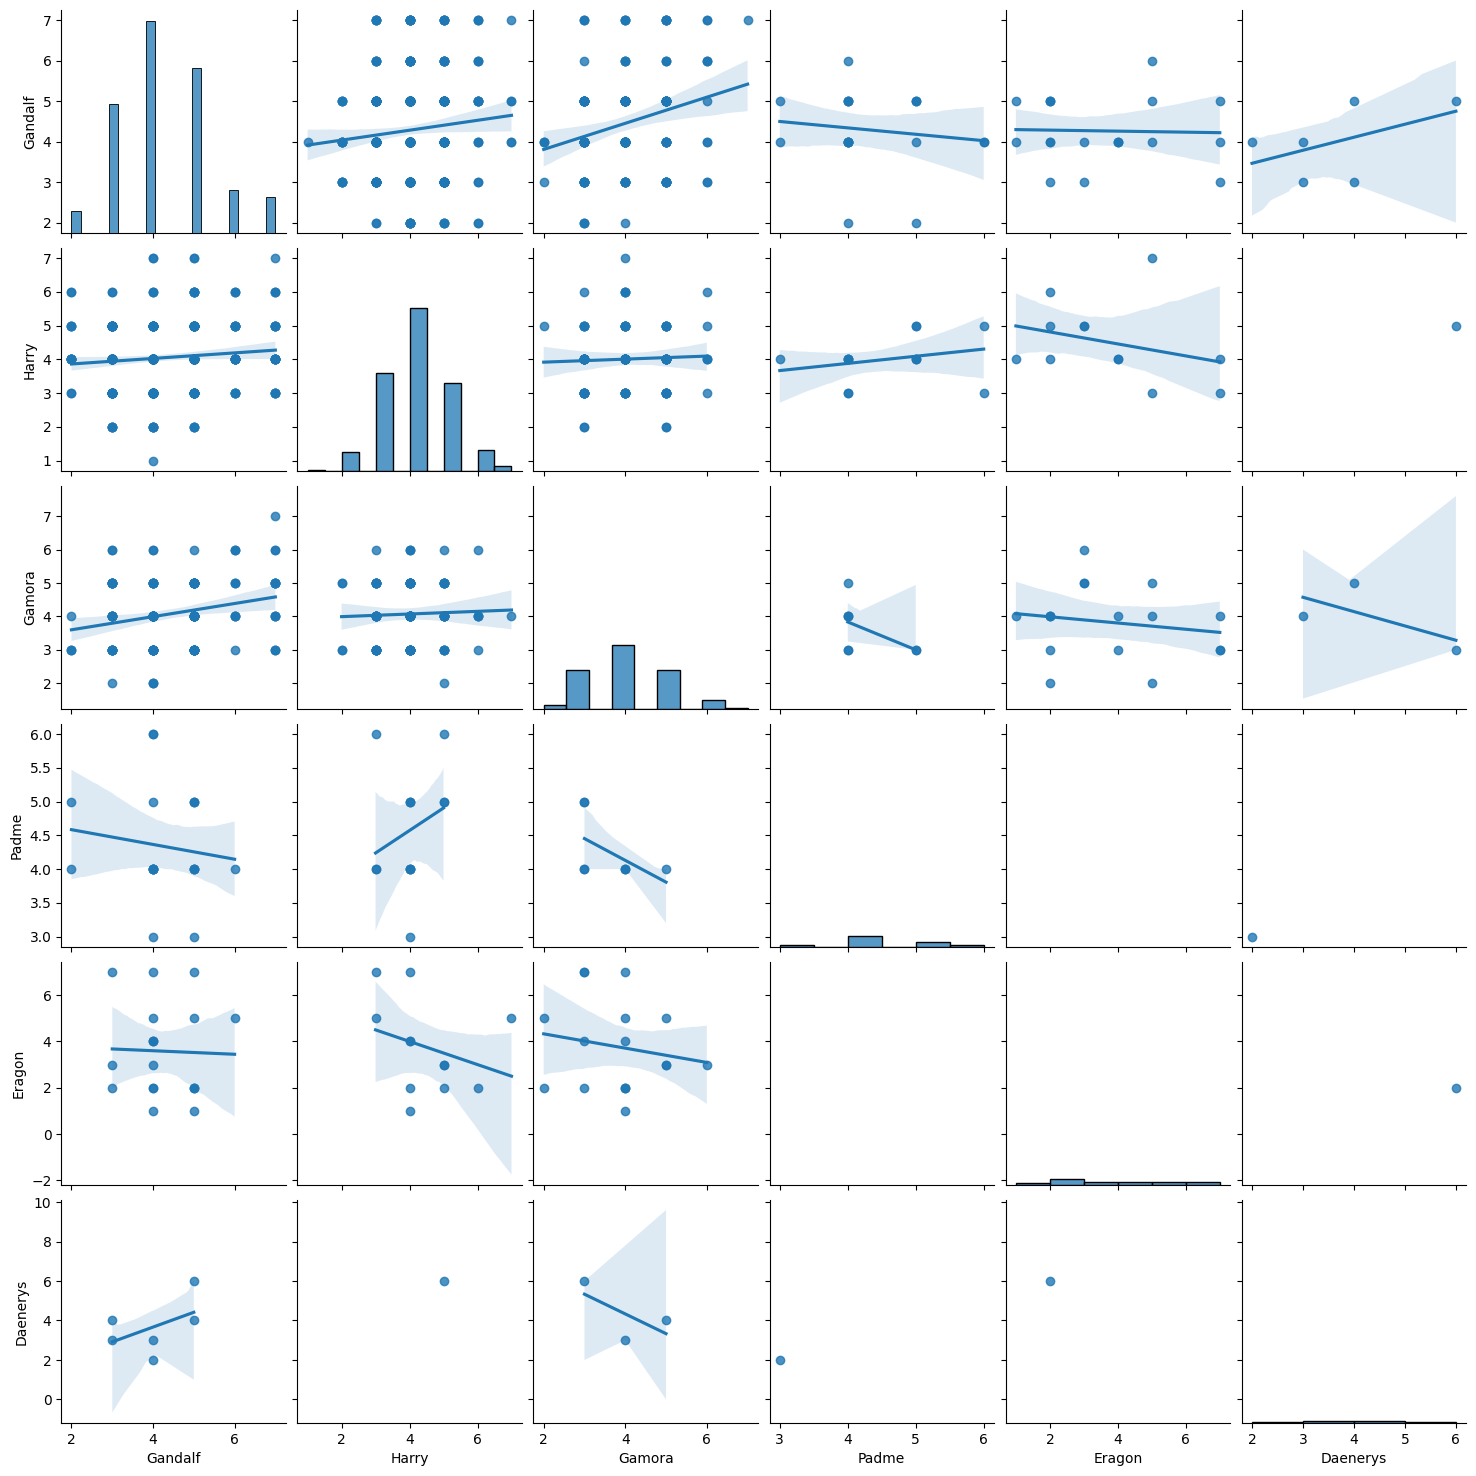

In [11]:
# Create dataframe
df = data.as_df()
df = df.drop('Puzzle Number', axis=1)

# Set up figure
f, myax = plt.subplots(1, 2)
f.set_figwidth(10)
f.suptitle('Figure 4: Correlation in solve scores', fontweight='bold')

# Calculate Pearson's r-squared and t-test p-values
correlation_matrix = df.corr()

# Create lists of each comparison and pearson value
comparison = []
pearson = []
for col,person_1 in enumerate(correlation_matrix):
    values = correlation_matrix[person_1]
    for row in range(col+1,len(values)):
        person_2 = values.index[row]
        comparison.append(person_1+'-'+person_2)
        pearson.append(values.iloc[row])

# Create correlation dataframe from lists and sort 
corr_list = pd.DataFrame({'Comparison':comparison, 'Pearson Value': pearson})
corr_list = corr_list.sort_values(by=['Pearson Value'], axis=0, ascending=False, na_position='last')

# Plot correlation bar chart
corr_list.plot.bar(x='Comparison',
                   y = 'Pearson Value',
                   legend=False,
                   title='Correlation between scores',
                   ylabel='Pearson Value',
                   ax=myax[0]
                   )

# Plot heatmap of correlation
sns.heatmap(data.rolling(19).transpose(),
                 cmap='turbo',
                 vmin=0,
                 vmax=6,
                 ax=myax[1])
myax[1].set(title='Rolling Average Heatmap',
       xlabel='Puzzle number')

# Add panel labels
labels = ['A','B','C']
for i in range(len(myax)):
      myax[i].text(-0.02,1.02, labels[i],
            transform=myax[i].transAxes,
            fontsize=16, fontweight='bold', va='bottom', ha='right')

# Seaborn pairplot of each person's score compared to others
g = sns.pairplot(df,kind='reg')



### Which letter slots are easiest to guess?
As each person guesses words, it is reasonable to assume that their guesses will most likely transition from mostly ⬜ (integer value of 1 = letter is not in word) to 🟨 (int value of 2 = right letter, wrong position) to mostly 🟩 (int value of 3, right letter in the right position). Is there a way to quantify this transition for each position in the 6 x 5 guess grid?

For each position in the 6 x 5 guess grid, the average numerical value of the letter's guess is calculated from the integer representation (1, 2, or 3). Spots that were not used for guesses (value of 0) were not included in the analysis. Therefore, values closer to 3 are better (the player guessed the letters) than low values (close to 1 means that the average letter in that spot was usually wrong). The warmer colors are higher in value. In the second row, these plots show the same data but use the value shown for each spot as the third graphing dimension as another way to visualize the data.

Predictably, as more guesses are used, the proportion of correctly placed letters increases. Values < 3 in guess row 6 indicates that the player did not completely solve some puzzles by that guess, lowering the letter score. Values of 0 mean the player never guessed a letter in that position.

c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\Code\wordlemodule.py:372: RuntimeWarning: Mean of empty slice
  person_avg= np.nanmean(person_attempted_puzzles_nan,axis=2)


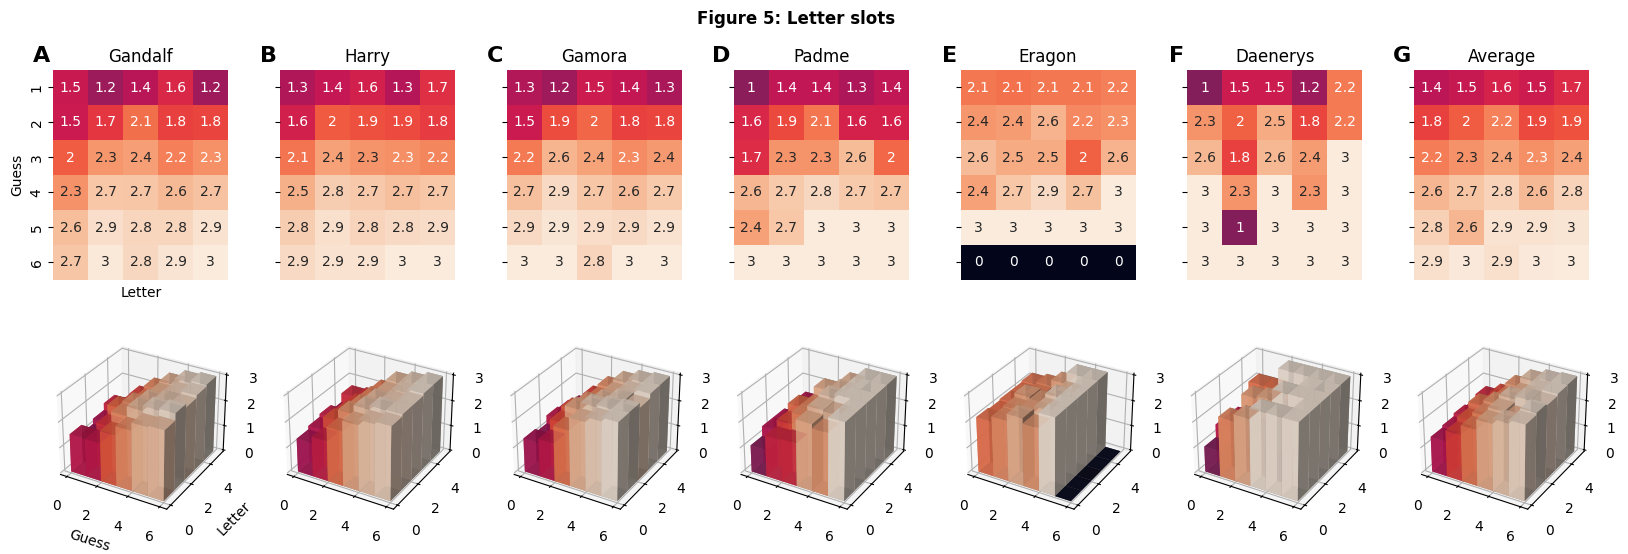

In [12]:
# Create dictionary with average scores per letter position
dt = data.puzz_avg()

# Set up figure
f, myax = plt.subplots(2, dt.keys().__len__(), sharey=True)
f.set_figwidth(20)
f.set_figheight(6)
f.suptitle('Figure 5: Letter slots', fontweight='bold')

# Plot heatmap and 3d barplot for each person
for i,person in enumerate(dt):
    sns.heatmap(dt[person],
                ax = myax[0,i],
                vmin = 0,
                vmax = 3,
                cbar = False,
                cmap = 'rocket',
                square = True,
                yticklabels = [1,2,3,4,5,6],
                xticklabels = [],
                annot = True)
    myax[0,i].set(title=person)
    

    y = np.arange(5)
    x = np.arange(6)
    _x, _y = np.meshgrid(x, y)
    X, Y = _x.ravel(), _y.ravel()

    dx = dy = 1
    dz = dt[person]
    dz = dz.T.ravel()
    zpos = np.zeros_like(dz)

    # Remove old axis and add new 3d projection axis in same spot
    myax[1,i].remove()
    ax = f.add_subplot(2, dt.keys().__len__(), 8+i, projection='3d')

    # Set colormap to mimic heatmap
    cmap = plt.get_cmap('rocket')
    colors = cmap(dz / 3)

    ax.bar3d(X,Y,zpos,dx,dy,dz, color=colors, alpha=0.8)

    # Add labels only to first 3dbar plot
    if i == 0:
        ax.set_xlabel('Guess')
        ax.set_ylabel('Letter')

myax[0,0].set(ylabel = 'Guess',
              xlabel = 'Letter')

# Add panel labels
labels = ['A','B','C','D','E','F','G',
          'A\'','B\'','C\'','D\'','E\'','F\'','G\'']
for i in range(myax.shape[0]):
      for j in range(myax.shape[1]):
            myax[i,j].text(-0.02,1.02, labels[(myax.shape[0]*i)+i+j],
                  transform=myax[i,j].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='right')

### What are the most common letter patterns and their guess rates?
In English, five-letter words can have certain patterns, for example, have the form of consonant-consonant-vowel-consonant-vowel, such as SLATE / BRAKE / THOSE and so on. Additionally, there are many similar words which vary only by a single letter, such as TEAMS / BEAMS / REAMS / SEAMS. Are these patterns revealed in the guesses of the words?

Although data for the actual letters guessed is unavailable, it is still possible to calculate the frequency of the results. For example, one would expect ⬜⬜⬜⬜⬜ (5 letters which are not in the word) to be the most common result for guesses in row 1, whereas we would expect 🟩🟩🟩🟩🟩 (5 letters in the correct spots) to be the most common result of guesses in row 6.

To calculate these frequencies, all guesses from each person for row 1 are combined, and then the frequency of the most common results are calculated. The same method is applied to rows 2-5. Results shown below reflect the 6 most common results and their percentage. For example, as expected, ⬜⬜⬜⬜⬜ is the most common result for row 1, occuring %8.95 out of all results.

Interestingly, the second most common result for every row has a white square in column 1 (such as ⬜🟩🟩🟩🟩). Furthermore, there is a large jump in the percentage between the second most and third most common results (for example, from row 5: %7.21⬜🟩🟩🟩🟩 vs %2.18🟩🟩⬜🟩🟩). Together, these indicate that the first letter of theh word is often most difficult to guess, possibly due to the large variability in single letter differences mentioned earlier.





In [14]:
# Calculate most frequent letter patterns
patterns, patterns_freq = data.letter_patterns()

# Set up dataframe
df = pd.DataFrame(index=[0])

# Add values to df
for i in range(6):

    # Add actual data
    datatoadd = Code.wordlemodule.int_to_char(patterns[:,:,i],patterns_freq[:,:,i])
    row = 'Row ' + str(i+1)
    df[row] = datatoadd

# Display table using HTML for nice formatting
display( HTML( df.to_html().replace("\\n","<br>") ) )


,Row 1,Row 2,Row 3,Row 4,Row 5,Row 6
0,%8.95⬜⬜⬜⬜⬜%7.08⬜⬜⬜🟨⬜%6.64🟨⬜⬜⬜⬜%6.41⬜⬜⬜⬜🟨%6.04🟨⬜⬜🟨⬜%5.97⬜⬜🟨⬜⬜,%4.25🟩🟩🟩🟩🟩%3.06⬜⬜🟨🟨⬜%2.46⬜⬜🟩⬜⬜%2.31⬜⬜🟨🟨🟨%2.31⬜🟨🟨⬜⬜%2.24⬜⬜🟨⬜⬜,%23.72🟩🟩🟩🟩🟩%4.35⬜🟩🟩🟩🟩%3.27🟩🟩🟩⬜🟩%2.95⬜⬜🟩🟩🟩%2.64⬜🟩🟩⬜🟩%2.33⬜🟩⬜🟩🟩,%52.42🟩🟩🟩🟩🟩%7.91⬜🟩🟩🟩🟩%2.98🟩⬜🟩🟩🟩%2.67🟩🟩🟩⬜🟩%2.16🟩🟩🟩⬜⬜%2.16⬜🟩⬜🟩🟩,%72.93🟩🟩🟩🟩🟩%7.21⬜🟩🟩🟩🟩%2.18🟩🟩⬜🟩🟩%1.75🟩⬜🟩🟩🟩%1.75🟩🟩🟩⬜🟩%1.09🟩🟩🟩🟩⬜,%82.35🟩🟩🟩🟩🟩%6.86⬜🟩🟩🟩🟩%3.92🟩🟩⬜🟩🟩%1.96⬜🟩⬜🟩🟩%0.98⬜⬜🟩🟩🟩%0.98🟩⬜🟩🟩🟩
